<a href="https://colab.research.google.com/github/remytr/Monte-Carlo-Simulations/blob/main/Monte_Carlo_Simulations_in_Quant_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Monte Carlo

In [6]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf


In [7]:
# Define the tickers we want to download
tickers = ['JPM', 'GS', 'MS', 'BLK', 'C']

# Download historical data for each ticker
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start='2023-01-01', end='2023-11-30')

# Display the first few rows of one of the datasets
print(data['JPM'].head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             JPM         JPM         JPM         JPM       JPM
Date                                                                
2023-01-03  126.709824  128.229001  125.556386  126.822364  11054800
2023-01-04  127.891418  129.110492  127.131837  127.525693  11687600
2023-01-05  127.863106  128.203193  126.304367  128.155956   8381300
2023-01-06  130.309845  130.725509  127.050685  128.599968  10029100
2023-01-09  129.771317  131.197799  129.308430  130.933289   8482300


In [8]:
class OptionContract:
    def __init__(self, strike, type, premium):
        self.strike = strike
        self.type = type
        self.premium = premium

    def payoff(self, spot):
        if self.type == 'call':
            return max(spot - self.strike, 0) - self.premium
        elif self.type == 'put':
            return max(self.strike - spot, 0) - self.premium
        else:
            raise ValueError("Option type must be 'call' or 'put'")

Text(0, 0.5, 'Price')

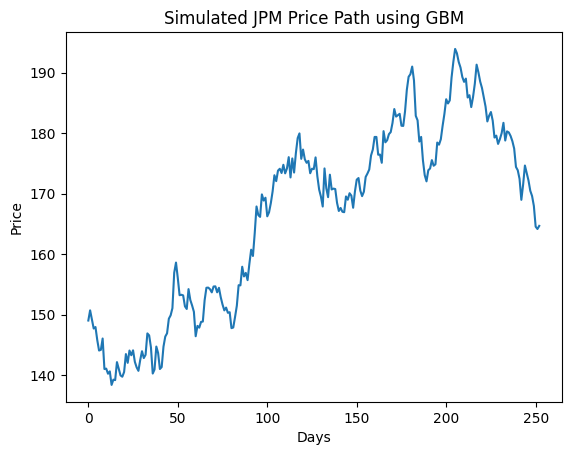

In [10]:
def simulate_gbm(s0, mu, sigma, t, steps):
    dt = t / steps
    prices = [s0]
    for _ in range(steps):
        prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal()))
    return prices

# Example usage
s0 = data['JPM']['Close'].iloc[-1]  # Last closing price as the starting price
mu = 0.05  # Assume an annual return of 5%
sigma = 0.2  # Assume an annual volatility of 20%
t = 1  # Simulate for 1 year
steps = 252  # Number of trading days in a year

simulated_prices = simulate_gbm(s0, mu, sigma, t, steps)
plt.plot(simulated_prices)
plt.title('Simulated JPM Price Path using GBM')
plt.xlabel('Days')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

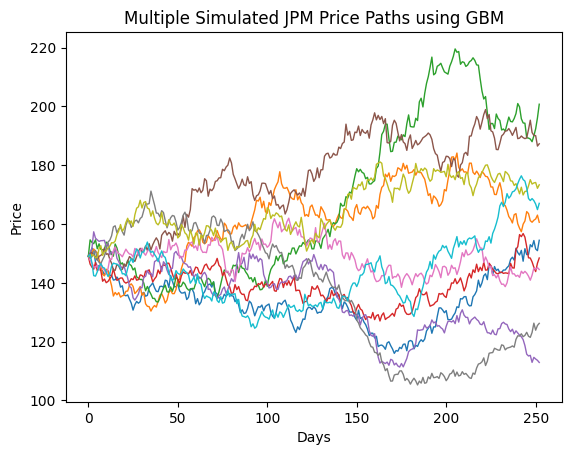

In [18]:
def simulate_multiple_gbm(s0, mu, sigma, t, steps, simulations):
    return [simulate_gbm(s0, mu, sigma, t, steps) for _ in range(simulations)]

# Example usage
simulations = 1000
multiple_simulated_prices = simulate_multiple_gbm(s0, mu, sigma, t, steps, simulations)

# Plotting the first 10 simulations
for i in range(10):
    plt.plot(multiple_simulated_prices[i], lw=1)
plt.title('Multiple Simulated JPM Price Paths using GBM')
plt.xlabel('Days')
plt.ylabel('Price')

In [20]:
def evaluate_long_call_strategy(option, simulated_prices):
    payoffs = []
    for price_path in simulated_prices:
        final_price = price_path[-1]
        # Convert to scalar if it's a pandas Series
        if hasattr(final_price, 'item'):
            final_price = final_price.item()
        elif hasattr(final_price, 'iloc'):
            final_price = float(final_price)

        payoffs.append(option.payoff(final_price))

    return np.mean(payoffs), np.std(payoffs)

# Example usage
strike_price = 130  # Example strike price
premium_paid = 5  # Premium paid for the option
long_call_option = OptionContract(strike_price, 'call', premium_paid)

mean_payoff, std_payoff = evaluate_long_call_strategy(long_call_option, multiple_simulated_prices)
print(f"Mean Payoff: {mean_payoff}, Standard Deviation of Payoff: {std_payoff}")

Mean Payoff: 23.98581431880226, Standard Deviation of Payoff: 27.033024516581584


Text(0, 0.5, 'Frequency')

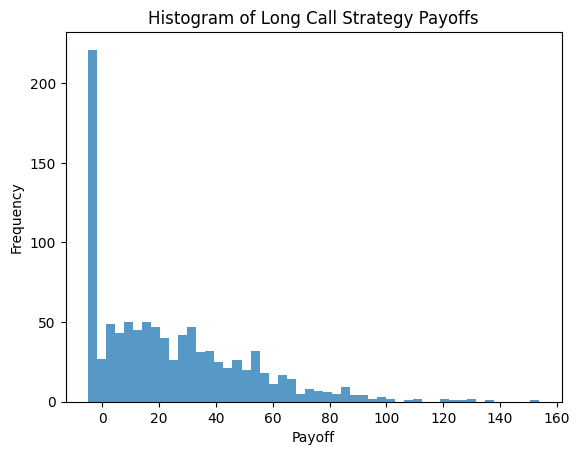

In [22]:
payoffs = []
for price in multiple_simulated_prices:
    final_price = price[-1]
    # Convert to scalar if needed
    if hasattr(final_price, 'item'):
        final_price = final_price.item()
    elif hasattr(final_price, 'iloc'):
        final_price = float(final_price)

    payoffs.append(long_call_option.payoff(final_price))

plt.hist(payoffs, bins=50, alpha=0.75)
plt.title('Histogram of Long Call Strategy Payoffs')
plt.xlabel('Payoff')
plt.ylabel('Frequency')

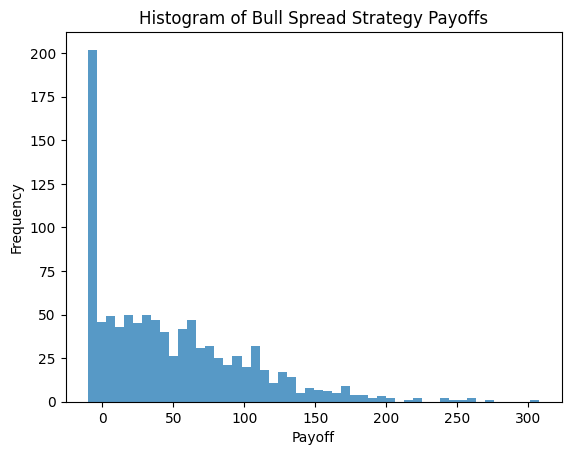

In [24]:
class BullSpreadStrategy:
    def __init__(self, long_call, short_call):
        self.long_call = long_call
        self.short_call = short_call

    def payoff(self, spot):
        return self.long_call.payoff(spot) + self.short_call.payoff(spot)

# Example usage
long_call = OptionContract(125, 'call', 7)
short_call = OptionContract(135, 'call', 3)
bull_spread = BullSpreadStrategy(long_call, short_call)

# Fixed payoff calculation
bull_spread_payoffs = []
for price in multiple_simulated_prices:
    final_price = price[-1]
    # Convert to scalar if needed
    if hasattr(final_price, 'item'):
        final_price = final_price.item()
    elif hasattr(final_price, 'iloc'):
        final_price = float(final_price)

    bull_spread_payoffs.append(bull_spread.payoff(final_price))

plt.hist(bull_spread_payoffs, bins=50, alpha=0.75)
plt.title('Histogram of Bull Spread Strategy Payoffs')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.show()